In [3]:
import os
from pathlib import Path

# Set working directory to the base directory 'gpudrive'
working_dir = Path.cwd()
while working_dir.name != 'gpudrive-CoDec':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive' not found")
os.chdir(working_dir)

In [5]:
import torch
import dataclasses
import mediapy
from huggingface_hub import PyTorchModelHubMixin
from huggingface_hub import ModelCard
from gpudrive.networks.late_fusion import NeuralNet

from gpudrive.env.config import EnvConfig
from gpudrive.env.env_torch import GPUDriveTorchEnv
from gpudrive.visualize.utils import img_from_fig
from gpudrive.env.dataset import SceneDataLoader
from gpudrive.utils.config import load_config

### Configs

In [6]:
# Configs model has been trained with
config = load_config("examples/experimental/config/reliable_agents_params")
print(config)

max_agents = config.max_controlled_agents
num_envs = 2
device = "cpu" # cpu just because we're in a notebook
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# config.max_controlled_agents = 1

{'max_controlled_agents': 64, 'ego_state': True, 'road_map_obs': True, 'partner_obs': True, 'norm_obs': True, 'remove_non_vehicles': True, 'lidar_obs': False, 'reward_type': 'weighted_combination', 'collision_weight': -0.75, 'off_road_weight': -0.75, 'goal_achieved_weight': 1.0, 'dynamics_model': 'classic', 'collision_behavior': 'ignore', 'dist_to_goal_threshold': 2.0, 'polyline_reduction_threshold': 0.1, 'sampling_seed': 42, 'obs_radius': 50.0, 'action_space_steer_disc': 13, 'action_space_accel_disc': 7, 'init_mode': 'all_non_trivial'}


### Load pre-trained agent via Hugging Face hub


In [7]:
sim_agent = NeuralNet.from_pretrained("daphne-cornelisse/policy_S10_000_02_27")

In [8]:
# Agent has an action dimension of 91: 13 steering wheel angle discretizations x 9 acceleration discretizations
sim_agent.action_dim

91

In [9]:
# Size of flattened observation vector
sim_agent.obs_dim

2984

In [10]:
# Some other info
card = ModelCard.load("daphne-cornelisse/policy_S10_000_02_27")
card.data.tags

['ffn', 'model_hub_mixin', 'pytorch_model_hub_mixin']

In [8]:
# Model architecture
#agent

In [9]:
# Weights 
#agent.state_dict()

### Make environment

In [11]:
# Create data loader
train_loader = SceneDataLoader(
    root='data/processed/examples',
    batch_size=num_envs,
    dataset_size=100,
    sample_with_replacement=False,
)

# Set params
env_config = dataclasses.replace(
    EnvConfig(),
    ego_state=config.ego_state,
    road_map_obs=config.road_map_obs,
    partner_obs=config.partner_obs,
    reward_type=config.reward_type,
    norm_obs=config.norm_obs,
    dynamics_model=config.dynamics_model,
    collision_behavior=config.collision_behavior,
    dist_to_goal_threshold=config.dist_to_goal_threshold,
    polyline_reduction_threshold=config.polyline_reduction_threshold,
    remove_non_vehicles=config.remove_non_vehicles,
    lidar_obs=config.lidar_obs,
    disable_classic_obs=config.lidar_obs,
    obs_radius=config.obs_radius,
    steer_actions = torch.round(
        torch.linspace(-torch.pi, torch.pi, config.action_space_steer_disc), decimals=3  
    ),
    accel_actions = torch.round(
        torch.linspace(-4.0, 4.0, config.action_space_accel_disc), decimals=3
    ),
)

# Make env
env = GPUDriveTorchEnv(
    config=env_config,
    data_loader=train_loader,
    max_cont_agents=config.max_controlled_agents,
    device=device,
)

In [12]:
env.data_batch

['data/processed/examples/tfrecord-00000-of-01000_325.json',
 'data/processed/examples/tfrecord-00000-of-01000_4.json']

### Use the agent

In [12]:
next_obs = env.reset()

control_mask = env.cont_agent_mask

next_obs.shape

torch.Size([2, 64, 2984])

In [13]:
action, logprob, entropy, value = sim_agent(
    next_obs[control_mask], deterministic=False
)

In [14]:
action.shape, logprob.shape, entropy.shape, value.shape

(torch.Size([2]), torch.Size([2]), torch.Size([2]), torch.Size([2, 1]))

In [15]:
curr_veh = control_mask.nonzero()[4]
control_mask[curr_veh[0], curr_veh[1]]
curr_veh

IndexError: index 4 is out of bounds for dimension 0 with size 2

In [ ]:
control_mask.nonzero()

tensor([[0, 0],
        [1, 1]])

### Rollout

In [13]:
next_obs = env.reset()

control_mask = env.cont_agent_mask

print(next_obs.shape)

frames = {f"env_{i}": [] for i in range(num_envs)}

for time_step in range(env.episode_len):
    print(f"\rStep: {time_step}", end="", flush=True)

    # Predict actions
    action, _, _, _ = sim_agent(
        next_obs[control_mask], deterministic=False
    )
    action_template = torch.zeros(
        (num_envs, max_agents), dtype=torch.int64, device=device
    )
    action_template[control_mask] = action.to(device)

    # Step
    env.step_dynamics(action_template)

    # Render    
    sim_states = env.vis.plot_simulator_state(
        env_indices=list(range(num_envs)),
        time_steps=[time_step]*num_envs,
        zoom_radius=70,
    )
    
    for i in range(num_envs):
        frames[f"env_{i}"].append(img_from_fig(sim_states[i])) 

    next_obs = env.get_obs()
    reward = env.get_rewards()
    done = env.get_dones()
    info = env.get_infos()
    
    if done.all():
        break

env.close()

torch.Size([2, 64, 2984])
Step: 54

env_0,env_1

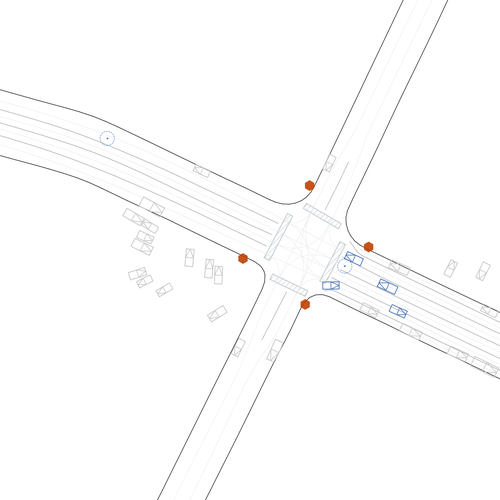
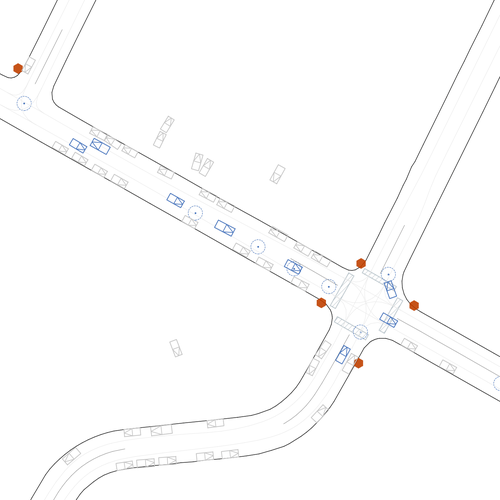

In [14]:
mediapy.set_show_save_dir('./sim_vids')
mediapy.show_videos(frames, fps=15, width=500, height=500, columns=2, codec='gif')

In [51]:
import numpy
with numpy.printoptions(threshold=numpy.inf):
    print(numpy.array(next_obs[0][30]))

[ 0.00000000e+00  1.53313056e-01  1.40020370e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.08084679e-02
 -2.18135715e-02 -2.41845563e-01  1.52492732e-01  1.38054043e-01
  0.00000000e+00  2.56059170e-02 -2.37950683e-02  2.62593836e-01
  1.82144821e-01  1.53100625e-01  0.00000000e+00  5.63085079e-03
 -3.70516181e-02 -4.95854646e-01  1.49495944e-01  1.36315122e-01
  0.00000000e+00  2.52205133e-02 -1.54880285e-02  2.56821036e-01
  2.46989220e-01  1.96135938e-01  1.01288937e-01  1.89779997e-02
  1.77681446e-03  2.59287924e-01  1.71420187e-01  1.45966783e-01
  0.00000000e+00  2.65166759e-02 -3.83775234e-02  2.59602338e-01
  1.99815318e-01  1.57437488e-01  0.00000000e+00  2.40441561e-02
  3.20863724e-03  2.60997206e-01  1.51350364e-01  1.32363722e-01
  0.00000000e+00  3.44669819e-03 -1.69116259e-02  4.96648818e-01
  1.58781335e-01  1.42393753e-01  0.00000000e+00  1.93154812e-03
 -2.87406445e-02  7.20994826e-03  1.60107940e-01  1.44566983e-01
  0.00000000e+00  2.28161

In [17]:
action.shape

torch.Size([13])

In [13]:

construal_size = 16
for const_num in range(int(max_agents/construal_size)):
    # Repeat rollout for each construal size

    next_obs = env.reset()
    control_mask = env.cont_agent_mask
    print("Observation shape: ", next_obs.shape)
    frames = {f"env_{i}-constr_{const_num}": [] for i in range(num_envs)}

    ## Defnie observation mask for construal
    obs_mask = [False]*next_obs.shape[2]                        # Dimension 3 (feature space)
    obs_mask = [obs_mask]*next_obs.shape[1]                     # Dimension 2 (total vehicles)
    obs_start_indx = int(const_num*construal_size)
    obs_end_indx = int((const_num+1)*construal_size)
    obs_mask[obs_start_indx:obs_end_indx] = [[True]*next_obs.shape[2]]*construal_size
    obs_mask = torch.tensor([obs_mask]*next_obs.shape[0])       # Dimension 1 (number of environments)
    
    for time_step in range(env.episode_len):
        ## Roll out policy for a specific construal
        print(f"\rStep: {time_step}", end="", flush=True)

        ### Predict actions
        action, _, _, _ = sim_agent(
            next_obs[control_mask], deterministic=False
        )
        action_template = torch.zeros(
            (num_envs, max_agents), dtype=torch.int64, device=device
        )
        action_template[control_mask] = action.to(device)

        ### Step
        env.step_dynamics(action_template)

        ### Render    
        sim_states = env.vis.plot_simulator_state(
            env_indices=list(range(num_envs)),
            time_steps=[time_step]*num_envs,
            zoom_radius=70,
        )
        
        for i in range(num_envs):
            frames[f"env_{i}-constr_{const_num}"].append(img_from_fig(sim_states[i])) 

        # next_obs = env.get_obs(obs_mask)
        next_obs = env.get_obs()
        reward = env.get_rewards()
        done = env.get_dones()
        info = env.get_infos()
        
        if done.all():
            break

    ## Save animations
    mediapy.set_show_save_dir('./sim_vids')
    mediapy.show_videos(frames, fps=15, width=500, height=500, columns=2, codec='gif')

# env.close()

Observation shape:  torch.Size([2, 64, 2984])
Step: 10

KeyboardInterrupt: 

In [37]:
action

tensor([90, 84])

In [36]:
env.get_obs()[obs_mask].shape

torch.Size([95488])

In [29]:
torch.masked.masked_tensor(env.get_obs(), obs_mask)

/home/sbanerjee/PyEnvs/gpuDrive/lib/python3.12/site-packages/torch/masked/maskedtensor/creation.py:19: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  return MaskedTensor(data, mask, requires_grad)


ValueError: data.dim() must equal mask.dim()